# Training loop

In questo notebook analizzeremo i vari passaggi necessari per il training di un modello.

In breve, un ciclo di addestramento si caratterizza di 3 fasi:

 - dataloader
 - training step
 - validation step
 
Sebbene la maggior parte delle librerie per ML fornisca delle utils già predisposte per eseguire questi passaggi, avere una panoramica delle varie fasi diventa fondamentale nel caso ci sia bisogno di **modifiche personalizzate** e per fini di **debugging**.  

## Dataloader

Il `Dataloader` è l'oggetto responsabile di leggere opportunamente i dati, accoppiare opportunamente input ed output, trasferirli dal disco in memoria sotto forma di **batch** e renderli disponibili per il processo di training.

La libreria fastai mette a disposizione diversi dataloader che implementano le operazioni fondamentali a seconda del task di learning in esame. Queste implementazioni sono tipicamente già sufficienti per use-case più studiati come il nostro, per questo motivo potremo sfruttare direttamente la classe `SegmentationDataLoaders` [[1]](https://docs.fast.ai/vision.data.html#segmentationdataloaders).

In particolare, potremo sfruttare l'implementazione del metodo `SegmentationDataLoaders.from_label_func()` e basterà predisporre i blocchi necessari per il suo funzionamento:

 - *path*: percoso dove sono i dati
 - *fnames*: lista percorsi di ciascun file di input
 - *label_func*: funzione che permette di associare a ciascun input la relativa annotazione
 - *bs*: batch size
 - *splitter*: funzione che restituisce `True` se il file appartiene al validation set, `False` altrimenti
 - *item_tfms*: transformazioni da applicare sui singoli file di input, prima del raggruppamento in batch
 - *batch_tfms*: trasformazioni da applicare a ciascun batch
 - *device*: dove caricare il batch risultante; "cuda" per usare GPU 




###  Percorsi immagini di train e validation

Per prima cosa raccogliamo in una lista i path completi di tutte le immagini di training e validation.

In [1]:
from fastai.vision.all import *

data_path = Path('../fluocells_data/all_images')

# read train/valid/test split dataframe
split_df = pd.read_csv(data_path.parent / 'split_df.csv')
trainval_fnames = [data_path / 'images' / fn
                   for fn in split_df.query("split=='train' or split=='valid'").filename]

trainval_fnames

[Path('../fluocells_data/all_images/images/Mar26bS2C1R2_LHl_200x_y.png'),
 Path('../fluocells_data/all_images/images/Mar26bS1C2R1_VLPAGr_200x_y.png'),
 Path('../fluocells_data/all_images/images/Mar26bS1C1R4_VLPAGl_200x_y.png'),
 Path('../fluocells_data/all_images/images/MAR38S1C3R1_DMR_20_o.png'),
 Path('../fluocells_data/all_images/images/Mar19bS1C4R3_DMl_200x_y.png'),
 Path('../fluocells_data/all_images/images/Mar20bS2C1R1_LHl_200x_y.png'),
 Path('../fluocells_data/all_images/images/Mar24bS1C2R3_LHr_200x_y.png'),
 Path('../fluocells_data/all_images/images/Mar26bS2C2R1_LHr_200x_y.png'),
 Path('../fluocells_data/all_images/images/Mar21bS1C1R3_VLPAGr_200x_y.png'),
 Path('../fluocells_data/all_images/images/Mar21bS1C4R2_LHl_200x_y.png'),
 Path('../fluocells_data/all_images/images/Mar37S1C2R1_DMr_200x_o.png'),
 Path('../fluocells_data/all_images/images/Mar22bS2C1R1_LHl_200x_y.png'),
 Path('../fluocells_data/all_images/images/Mar23bS1C2R4_VLPAGl_200x_y.png'),
 Path('../fluocells_data/all_i

### label_func

Avremo bisogno poi di una funzione in grado di associare ad ogni immagine di input il path della corrispettiva maschera/annotazione. 

In [2]:
def label_func(p):
    return Path(str(p).replace('images', 'masks'))

In [3]:
print('Esempio:\n')

print(f'Input: {trainval_fnames[0]}')
print(f'Output: {label_func(trainval_fnames[0])}')

Esempio:

Input: ../fluocells_data/all_images/images/Mar26bS2C1R2_LHl_200x_y.png
Output: ../fluocells_data/all_masks/masks/Mar26bS2C1R2_LHl_200x_y.png


### Splitter

Infine, costruiamo una funzione che ci permetta di distinguere tra le immagini da usare per il training e quelle per la validazione. In particolare, questa funzione resituirà `True` per tutte le immagini registrate come `valid` in `split_df`;`False` altrimenti.

In [4]:
sample_img_names = ['Mar32bS2C2R2_DMl_200x_y.png', 'Mar27bS1C2R1_LHr_200x_y.png',
                    'Mar26bS2C1R2_LHr_200x_y.png', 'Mar41S3C1R1_DMr_200x_o.png']

print('split dataframe:\n', split_df.loc[split_df.filename.isin(sample_img_names)])

def is_valid(p):
    return split_df.loc[split_df.filename == p.name, 'split'].values[0] == 'valid'

print('splitter:\n')
for fn in sample_img_names:
    print(data_path / 'images' / fn, '\tvalidation set:', is_valid(data_path / 'images' / fn))

split dataframe:
      img_id                     filename  split
81       81   Mar41S3C1R1_DMr_200x_o.png  train
194     194  Mar32bS2C2R2_DMl_200x_y.png  train
196     196  Mar26bS2C1R2_LHr_200x_y.png  valid
248     248  Mar27bS1C2R1_LHr_200x_y.png  valid
splitter:

../fluocells_data/all_images/images/Mar32bS2C2R2_DMl_200x_y.png 	validation set: False
../fluocells_data/all_images/images/Mar27bS1C2R1_LHr_200x_y.png 	validation set: True
../fluocells_data/all_images/images/Mar26bS2C1R2_LHr_200x_y.png 	validation set: True
../fluocells_data/all_images/images/Mar41S3C1R1_DMr_200x_o.png 	validation set: False


### Dataloader 

In [5]:
# augmentation
tfms = [
    IntToFloatTensor(div_mask=255.),  # need masks in [0, 1] format
    RandomCrop(512),
    *aug_transforms(
        size=224, # resize
        max_lighting=0.1, p_lighting=0.5, # variazione luminosità
        min_zoom=0.9, max_zoom=1.1, # zoom
        max_warp=0, # distorsione
        max_rotate=15.0 # rotazione
    )
]


# splitter
splitter = FuncSplitter(lambda p: is_valid(p))
# alternative: random splitter
# RandomSplitter(valid_pct=0.3, seed=42),

BS = 32
# dataloader
dls = SegmentationDataLoaders.from_label_func(
    data_path, fnames=trainval_fnames, label_func=label_func,
    bs=BS,
    splitter=splitter,
    #     item_tfms=pre_tfms,
    batch_tfms=tfms,
    device='cuda'
)

# test
x, y = dls.one_batch()
print(x.shape, y.shape)
x.min(), x.max(), y.min(), y.max()

/home/luca/anaconda3/envs/fx/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


torch.Size([32, 3, 224, 224]) torch.Size([32, 224, 224])


(TensorImage(1.8184e-08, device='cuda:0'),
 TensorImage(0.9821, device='cuda:0'),
 TensorMask(0, device='cuda:0'),
 TensorMask(1, device='cuda:0'))

<div class="alert alert-block alert-info">

fastai permette di raggruppare le trasformazioni in due blocchi a seconda di quando vengono eseguite:
 - `item_tfms`: sono applicate prima della formazione del batch, quindi sul singolo input
 - `batch_tfms`: sono applicate sull'intero batch (eseguite su GPU se `device='cuda'`)
    
</div>

## Training/validation step

Per quanto riguarda le fasi di training e validation, fastai permette di gestirle tramite la classe `Learner`.

Oggetti di questo tipo, infatti, interagiscono con tutte le componenti necessarie per l'addestramento:
 - dataloader
 - modello
 - ottimizzatore
 
In particolare, il processo di training è gestito tramite il metodo `.fit()` che di fatto esegue ciascuna epoca di addestramento.

Inoltre, fastai permette di modificare il funzionamento standard della procedura di training tramite **callbacks** di varia natura (logging metriche, salvataggio configurazione pesi, early stopping, regole di aggiornamento parametri, ...).

### Iperparametri

Per prima cosa raccogliamo in un dizionario tutti gli iperparametri che utilizzeremo nei prossimi passaggi. 

Questo è molto utile per tenere traccia della configurazione usata in ciascun esperimento di training e permettere di ricostruire a posteriori tutte le impostazioni che hanno portato ad un determinato risultato.

<div class="alert alert-block alert-info">
    
Questa pratica è altamente consigliata in quanto è molto semplice arrivare in fondo ad una serie di esperimenti e non essere in grado di ricostruire la configurazione precisa utilizzata. 
    
Per questo motivo è altamente consigliato:
 - riportare insieme tutti gli iperparametri dei nostri esperimenti, in modo da fornire un unico punto di accesso per eventuali modifiche (possibilmente posto all'inizio in modo da essere facilmente individuabile)
 - salvare la configurazione di ogni esperimento insieme ai relativi risultati
</div>

In [6]:
import sys
sys.path.insert(0, str(Path.cwd().parent))

from utils import write_config, load_config

# data and augmentation params
CROP_SIZE = 512
RESIZE = 224
MAX_LIGHT = 0.1
ZOOM_DELTA = 0.9  # min_zoom = 1 - ZOOM_DELTA; max_zoom = 1 + ZOOM_DELTA
MAX_ROTATION_ANGLE = 15.0

# model params
N_IN, N_OUT = 16, 2

# optimizer params
W_CELL, W_BKGD = 100, 1
LOSS_FUNC, LOSS_NAME = CrossEntropyLossFlat(
    axis=1, weight=torch.Tensor([W_BKGD, W_CELL])), 'CrossEntropy'
LR = 0.001
OPT, OPT_NAME = partial(Adam, lr=LR), 'Adam'
MONIT_SCORE, MIN_DELTA, PATIENCE_ES = 'valid_loss', 0, 20 # early stopping
FACTOR, PATIENCE_LR = 10/7, 4 # scheduling learning rate


hyperparameter_defaults = dict(
    crop_size=CROP_SIZE,
    resize=RESIZE,
    batch_size=BS,
    angle=MAX_ROTATION_ANGLE,
    zoom_delta=ZOOM_DELTA,
    max_light=MAX_LIGHT,
    # model
    n_in=N_IN, n_out=N_OUT,
    # optimizer
    loss_func=LOSS_FUNC, loss_name=LOSS_NAME,
    lr=LR,
    opt=OPT, opt_name=OPT_NAME,
    monit_dict={'score': MONIT_SCORE, 'min_delta': MIN_DELTA, 'patience': PATIENCE_ES},
    lr_monit_dict={'factor': FACTOR, 'patience': PATIENCE_LR},
)

cfg = namedtuple('Config', hyperparameter_defaults.keys())(
    **hyperparameter_defaults)

# save config
EXP_NAME = f'test-training-loop:wcell={W_CELL}'
log_path = Path().cwd().parent / 'logs' / EXP_NAME  
log_path.mkdir(exist_ok=True, parents=True)
write_config(hyperparameter_defaults, log_path / "cfg.pkl")
# loaded_cfg = load_config(log_path / "cfg.pkl")

### Modello 

In [7]:
from blocks import cResUnet

model = cResUnet(cfg.n_in, cfg.n_out)

In [8]:
model

cResUnet(
  (encoder): ModuleDict(
    (colorspace): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
    (conv_block): ConvBlock(
      (conv_block): ModuleDict(
        (batchnorm2d_0): BatchNorm2d(1, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (activation_1): ELU(alpha=1.0)
        (conv2d_2): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchnorm2d_3): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (activation_4): ELU(alpha=1.0)
        (conv2d_5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (residual_block1): ResidualBlock(
      (conv_path): ConvBlock(
        (conv_block): ModuleDict(
          (batchnorm2d_0): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (activation_1): ELU(alpha=1.0)
          (conv2d_2): Con

### Callbacks

In [9]:
CBS = [
#     ReduceLROnPlateau(monitor=MONIT_SCORE,
#                       patience=PATIENCE_LR, factor=FACTOR),
#     EarlyStoppingCallback(monitor=MONIT_SCORE,
#                           min_delta=MIN_DELTA, patience=PATIENCE_ES),
#     SaveModelCallback(monitor=MONIT_SCORE, min_delta=MIN_DELTA, fname='model',
#                       every_epoch=False, at_end=False, with_opt=False, reset_on_fit=False),
    CSVLogger
]

## Learner

In [10]:
learn = Learner(dls, model=model, loss_func=cfg.loss_func,
                metrics=[Dice(), JaccardCoeff(), foreground_acc],
                cbs=CBS,
                path=log_path , 
                model_dir=f'{log_path.parent.parent}/models/{EXP_NAME}',
                )  

print(
    f'Logs save path: {learn.path}\nModel save path: {learn.path / learn.model_dir}')

learn.summary()

Logs save path: /home/luca/PycharmProjects/c-resunet-DLI/logs/test-training-loop:wcell=100
Model save path: /home/luca/PycharmProjects/c-resunet-DLI/models/test-training-loop:wcell=100


/home/luca/anaconda3/envs/fx/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


cResUnet (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 1 x 224 x 224  
Conv2d                                    4          True      
BatchNorm2d                               2          True      
ELU                                                            
____________________________________________________________________________
                     32 x 16 x 224 x 224 
Conv2d                                    160        True      
BatchNorm2d                               32         True      
ELU                                                            
Conv2d                                    2320       True      
____________________________________________________________________________
                     32 x 16 x 112 x 112 
MaxPool2d                                                      
BatchNorm2d                               32         True      
ELU                                  

### .fit()

Il metodo `.fit()` della classe `Learner` è l'elemento che permette di gestire il ciclo di training standard in fastai. Per prima cosa possiamo dare uno sguardo al suo codice.

In [11]:
learn.fit??

```
Signature: learn.fit(n_epoch, lr=None, wd=None, cbs=None, reset_opt=False)
Docstring: Fit `self.model` for `n_epoch` using `cbs`. Optionally `reset_opt`.
Source:   
    def fit(self, n_epoch, lr=None, wd=None, cbs=None, reset_opt=False):
        with self.added_cbs(cbs):
            if reset_opt or not self.opt: self.create_opt()
            if wd is None: wd = self.wd
            if wd is not None: self.opt.set_hypers(wd=wd)
            self.opt.set_hypers(lr=self.lr if lr is None else lr)
            self.n_epoch = n_epoch
            self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
File:      ~/anaconda3/envs/fx/lib/python3.9/site-packages/fastai/learner.py
Type:      method

```

Come di consueto in fastai, il codice è molto essenziale e modulare, riducendo anche routine complesse come il training di un modello a poche righe di codice.

In pratica, il tutto si riduce ad una scomposizione del training in tutti i suoi componenti fondamentali. 
In fastai, questi componenti sono chiamati **events** e si distinguono in 5 tipi con crescente livello di specializzazione:

 - *Fit*
 - *Epoch*
 - *Train*
 - *Validate*
 - *Batch*
 
Ciascuno di questi poi può richiedere l'esecuzione di operazioni in 3 fasi diverse:

 - *before_{event_type}*: prima, in preparazione all'evento
 - *after_{event_type}*: dopo, per ripulire e predisporre i passi successivi
 - *after_cancel_{event_type}*: in caso qualche operazione non vada a buon fine
 
Partendo da questi blocchi, lo schema completo delle operazioni racchiuse in un ciclo di training è rappresentato nel control flow di seguito.

![Control Flow fastai fit operation](https://miro.medium.com/max/2000/1*ZCqbw_9Qk6lLbWOn1KrhYg.png)

Infine, è possibile personalizzare l'esecuzione di questi step attraverso **callback** opportunamente implementate per integrarsi al livello di eventi desiderato e modificarne il funzionamento.
Per fare questo è sufficiente passare la callback al momento della creazione del learner o all'esecuzione del fit tramite l'argomento **cbs**.

<div class="alert alert-block alert-info">

Per maggiori informazioni si suggerisce di controllare la documentazione [[1](https://docs.fast.ai/learner.html#learner.fit), [2](https://docs.fast.ai/callback.core.html)] o questo [blog post](https://medium.com/analytics-vidhya/understanding-fastai-v2-training-with-a-computer-vision-example-part-3-fastai-learner-and-a3ea85c6fe78).   
</div>.


In [12]:
learn.fit(n_epoch=1, lr=cfg.lr)

epoch,train_loss,valid_loss,dice,jaccard_coeff,foreground_acc,time
0,0.557394,0.676412,0.000000,0.000000,0.000000,00:13


### .lr_find()

La scelta del learning rate è molto importante per indirizzare l'apprendimento, per cui questa scelta richiede tipicamente diversi esperimenti.
Per fortuna, fastai implementa una comoda routine, `lr_find` [[1]](https://docs.fast.ai/callback.schedule.html#lrfinder), in grado di suggerire un buon valore iniziale per questo iperparametro.

In pratica, questa si basa su una grid-search su un sottoinsieme dei dati che prova con learning rate a diversi ordini di grandezza e restituisce la loss calcolata su alcuni batch.
Il tutto è riassunto nel grafico di sotto.
Per maggiori informazioni [[L. Smith (2018)*](https://arxiv.org/abs/1803.09820), [2](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html), [3](https://stackoverflow.com/a/62986041/7678074)].

<div class="alert alert-block alert-info">
* il paper discute anche molti altri dettagli su come migliorare/velocizzare il training di un modello ed è una lettura assolutamente consigliata!
</div>



SuggestedLRs(valley=0.0012022644514217973)

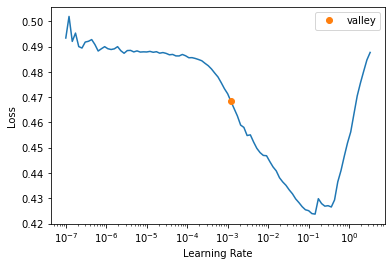

In [13]:
res = learn.lr_find()
res

L'idea è che valori all'inizio dell'andamento discendente dovrebbero facilitare la convergenza verso un minimo in maniera comparativamente veloce, ed è restituita tramite l'argomento `valley`. 

In [14]:
# update config
cfg._replace(lr=res.valley)
cfg._replace(opt=partial(Adam, lr=cfg.lr))

learn.fit(1, lr=cfg.lr)

epoch,train_loss,valid_loss,dice,jaccard_coeff,foreground_acc,time
0,0.456167,0.792855,0.013121,0.006604,0.993649,00:11


### .fit_one_cycle()

Per concludere, fastai mette a disposizione alcune utils che implementano strategie di training spesso utilizzate in letteratura ML.

Una di queste è il metodo `.fit_one_cycle()` che implementa la **1cycle policy** proposta nell'articolo di [L. Smith, (2018)](https://arxiv.org/abs/1803.09820).

L'osservazione di base è che spesso il training finisce per convergere in punti di sella (flessi multidimensionali) e minimi locali nei quali rimane impantanato.
Per ovviare a ciò, l'autore suggerisce una strategia di *scheduling* del learning rate all'interno di ciascuna epoch, che favorisce la convergenza verso soluzioni più stabili. 

![1cycleLR](https://miro.medium.com/max/913/1*fmgYmIAcYd18mqX5Oegc3w.png)

In pratica, questo ciclo si compone di 3 parti in cui il learning rate varia:

 - è tenuto basso all'inizio per avviare la convergenza senza però indirizzarsi addentrarsi fin da subito in un minimo
 - di seguito viene poi incrementato gradualmente per permettere una maggiore esplorazione della superficie della loss e favorire la convergenza verso un'area più piatta
 - infine viene ridotto gradualmente per permettere una convergenza verso un minimo prensente in quella zona

<div class="alert alert-block alert-info">

Per delle spiegazioni informali si suggeriscono questi blog post [[1](https://sgugger.github.io/the-1cycle-policy.html), [2](https://towardsdatascience.com/why-i-use-fastai-and-you-should-too-a421f6c99508)].   
</div>

In [15]:
learn.fit_one_cycle(n_epoch=1, lr_max=cfg.lr)

epoch,train_loss,valid_loss,dice,jaccard_coeff,foreground_acc,time
0,0.388504,0.814674,0.013100,0.006593,0.993938,00:11


### CUDA Out Of Memory Error

In [ ]:
BS = 256
dls = SegmentationDataLoaders.from_label_func(data_path, fnames=get_image_files(
    data_path / 'images'), label_func=label_func, bs=BS, device='cuda')

learn = Learner(dls, model=model, loss_func=cfg.loss_func,
                metrics=[Dice(), JaccardCoeff(), foreground_acc],
                cbs=CBS,
                path=log_path , 
                model_dir=f'{log_path.parent.parent}/models/{EXP_NAME}',
                )  

learn.fit(1, lr=cfg.lr)

<div class="alert alert-block alert-warning">

Questo codice potrebbe portare ad un errore di tipo `RuntimeError: CUDA out of memory`. 
Se ciò avviene, la ragione è che la GPU che state usando non ha sufficiente memoria per caricare il modello e un batch. 
    
In generale, questo è un errore che capita spesso di affrontare in esperimenti reali ed è bene avere un'idea di come affrontarlo. 
Un possibile rimedio è quello di **ridurre la batch size**, riducendo così il peso dei dati caricati in sulla GPU ad ogni batch.
Alternativamente, si potrebbe pensare di applicare un pre-processing che riduca la dimensione dei file di input, e.g. fare un crop/resize di dimensioni inferiori nel caso di immagini.
Infine, si può provare semplicemente ad usare un modello con meno parametri che quindi occuperà meno spazio in memoria.
    
Tuttavia, non sempre questi tentativi vanno a buon fine e l'unica soluzione potrebbe essere l'utilizzo di un hardware più performante o il ricorso a CPU anzichè GPU.
</div>